In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from dataset_spliter import SplitByPatient

In [3]:
import cv2
from fastai import *
from fastai.vision import *
from augmentation import cutout

In [4]:
path = Path('/data/Datasets/WhiteBloodCancer/train/')

In [5]:
fnames = get_image_files(path, recurse=True)
fnames[:5]

[PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H10_43_1_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H22_31_15_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H14_9_11_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H14_28_6_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H10_189_1_hem.bmp')]

In [6]:
len(fnames)

10661

In [7]:
hem_regex = re.compile(r'UID_(H[0-9]+)_', re.IGNORECASE)
all_regex = re.compile(r'UID_([0-9]+)_', re.IGNORECASE)

In [8]:
hem_files = [fn for fn in fnames if hem_regex.search(str(fn)) is not None]
all_files = [fn for fn in fnames if all_regex.search(str(fn)) is not None]

In [9]:
len(hem_files+all_files)

10661

### Cell shape statistics

In [8]:
def count_cell_pixels(fn : Path):
    
    image = cv2.cvtColor(cv2.imread(str(fn)), cv2.COLOR_BGR2RGB)
    return len(np.nonzero(image[:, :, 0])[0])    

In [9]:
hem_size = [count_cell_pixels(fn) for fn in tqdm(hem_files)]
all_size = [count_cell_pixels(fn) for fn in tqdm(all_files)]

100%|██████████| 7272/7272 [00:17<00:00, 423.63it/s]


In [10]:
print("Hem pixels {}:".format((np.mean(hem_size, dtype=np.int), np.std(hem_size, dtype=np.int))))
print("ALL pixels{}:".format((np.mean(all_size, dtype=np.int), np.std(all_size, dtype=np.int))))

Hem pixels (26544, 7762):
ALL pixels(36244, 7176):


In [11]:
def def_get_cell_size(fn: Path):
    
    image = cv2.cvtColor(cv2.imread(str(fn)), cv2.COLOR_BGR2RGB)
    
    rows = np.any(image, axis=1)
    cols = np.any(image, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    
    return rmax-rmin, cmax-cmin

In [12]:
result = [def_get_cell_size(fn) for fn in tqdm(hem_files+all_files)]
height, width = zip(*result)

100%|██████████| 10625/10625 [01:20<00:00, 132.09it/s]


In [13]:
print("Mean width: {}".format(np.mean(width, dtype=np.int)))
print("Mean height: {}".format(np.mean(height, dtype=np.int)))

print("Min width: {}".format(np.min(width)))
print("Min height: {}".format(np.min(height)))
      
print("Max width: {}".format(np.max(width)))
print("Max height: {}".format(np.max(height)))

Mean width: 211
Mean height: 209
Min width: 69
Min height: 79
Max width: 433
Max height: 441


### Create COCO like Dataset 

In [25]:
import json


CATEGORIES = [
    {
        'id': 1,
        'name': 'all',
        'supercategory': 'BloodCell',
    },
    {
        'id': 2,
        'name': 'hem',
        'supercategory': 'BloodCell',
    },
]

coco_output = {
    #"info": INFO,
    #"licenses": LICENSES,
    "categories": CATEGORIES,
    "images": [],
    "annotations": []
}

image_id = 1
annotation_id = 1
for fn in tqdm(hem_files+all_files):

    image = cv2.cvtColor(cv2.imread(str(fn)), cv2.COLOR_BGR2RGB)
    
    image_info = {
        "id": image_id,
        "file_name": fn.name,
        "width": image.shape[0],
        "height": image.shape[1],
    } 
    coco_output["images"].append(image_info)
    
    class_id  = 1 if 'all.' in str(fn) else 2
    
    rows = np.any(image, axis=1)
    cols = np.any(image, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    
    annotation_info = {
        "id": annotation_id,
        "image_id": image_id,
        "category_id": class_id,
        "bbox": [int(cmin),int(rmin),int(cmax-cmin),int(rmax-rmin)]
    }
    coco_output["annotations"].append(annotation_info)
    
    image_id += 1
    annotation_id = annotation_id + 1
    
with open('WhiteBloodCellCoco.json', 'w') as output_json_file:
    json.dump(coco_output, output_json_file)
    

100%|██████████| 10661/10661 [01:17<00:00, 137.00it/s]


### Dataset statistics

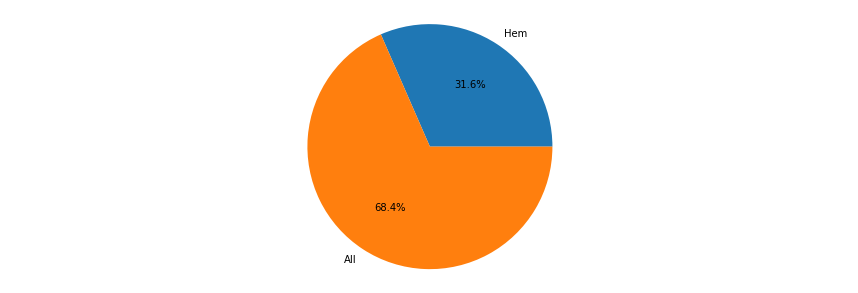

In [14]:
# Data to plot
labels, sizes = ['Hem', 'All'], [len(hem_files), len(all_files)]

plt.figure(figsize=(15,5))
# Plot
plt.pie(sizes, labels=labels, autopct='%1.1f%%')

plt.axis('equal')
plt.show()

#### Patient statistics

In [10]:
hem_patient_ids = list(set([hem_regex.search(str(fn)).group(1)
                            for fn in fnames if hem_regex.search(str(fn)) is not None]))
print('Hem IDs: ' + ' '.join(hem_patient_ids))
print("Count: {}".format(len(hem_patient_ids)))

Hem IDs: H22 H10 H15 H17 H11 H6 H40 H12 H1 H18 H23 H24 H14 H46 H13 H5 H4 h3 H7 H48 H2 H16 H8 H19 H20 H9
Count: 26


In [11]:
all_patint_ids = list(set([all_regex.search(str(fn)).group(1)
                           for fn in fnames if all_regex.search(str(fn)) is not None]))
print('All IDs: ' + ' '.join(all_patint_ids))
print("Count: {}".format(len(all_patint_ids)))

All IDs: 47 3 22 34 15 20 74 17 45 68 14 48 27 13 46 35 4 1 25 18 11 51 38 43 37 5 78 19 28 23 75 36 44 16 49 31 33 30 50 26 52 21 72 67 32 24 2
Count: 47


In [12]:
hem_patients = dict((k,[]) for k in hem_patient_ids)
all_patints = dict((k,[]) for k in all_patint_ids)

[all_patints[key].append(fn) for key in all_patints.keys() for fn in fnames if 'UID_{0}_'.format(key) in str(fn)]
[hem_patients[key].append(fn) for key in hem_patients.keys() for fn in fnames if 'UID_{0}_'.format(key) in str(fn)]

print()

154.72340425531914
9
757


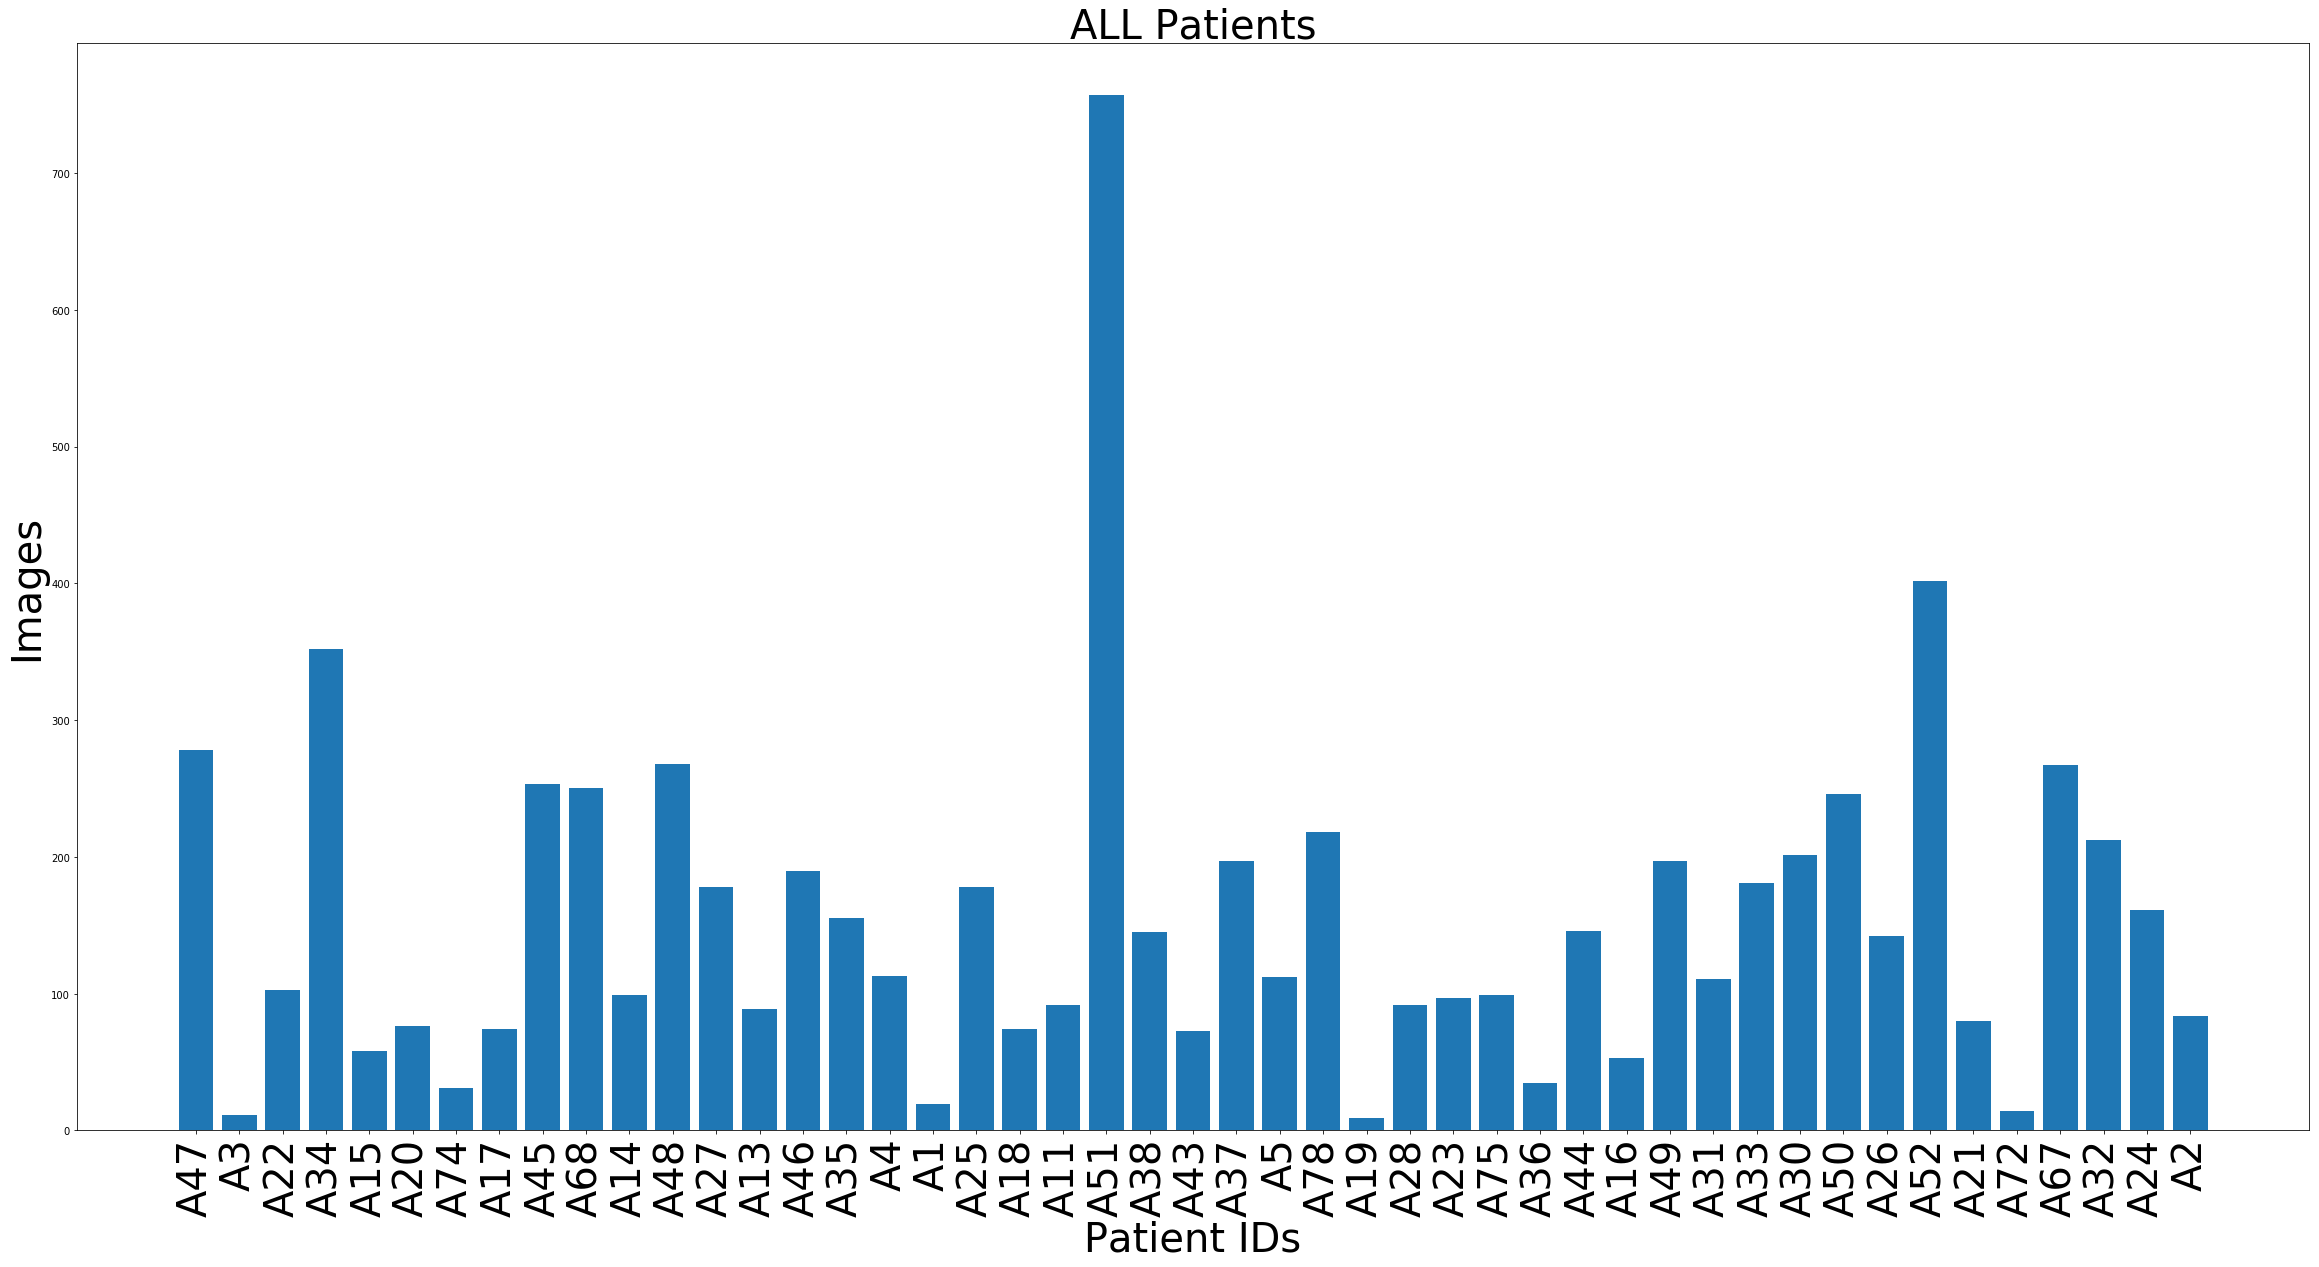

In [13]:
labels, sizes = zip(*[('A{}'.format(key), len(all_patints[key])) for key in all_patints.keys()])
x_pos = [i for i, _ in enumerate(labels)]

print(np.mean(sizes))
print(min(sizes))
print(max(sizes))

plt.figure(figsize=(40,20))
plt.bar(x_pos, sizes)
plt.xlabel("Patient IDs", fontsize=40)
plt.ylabel("Images", fontsize=40)
plt.title("ALL Patients", fontsize=40)

#for i, v in enumerate(sizes):
#    plt.text(x=v,y=i,s=str(v), color='blue', fontweight='bold', fontsize=40)

plt.xticks(x_pos, labels, rotation='vertical', fontsize=40)
plt.show()

130.34615384615384
9
405


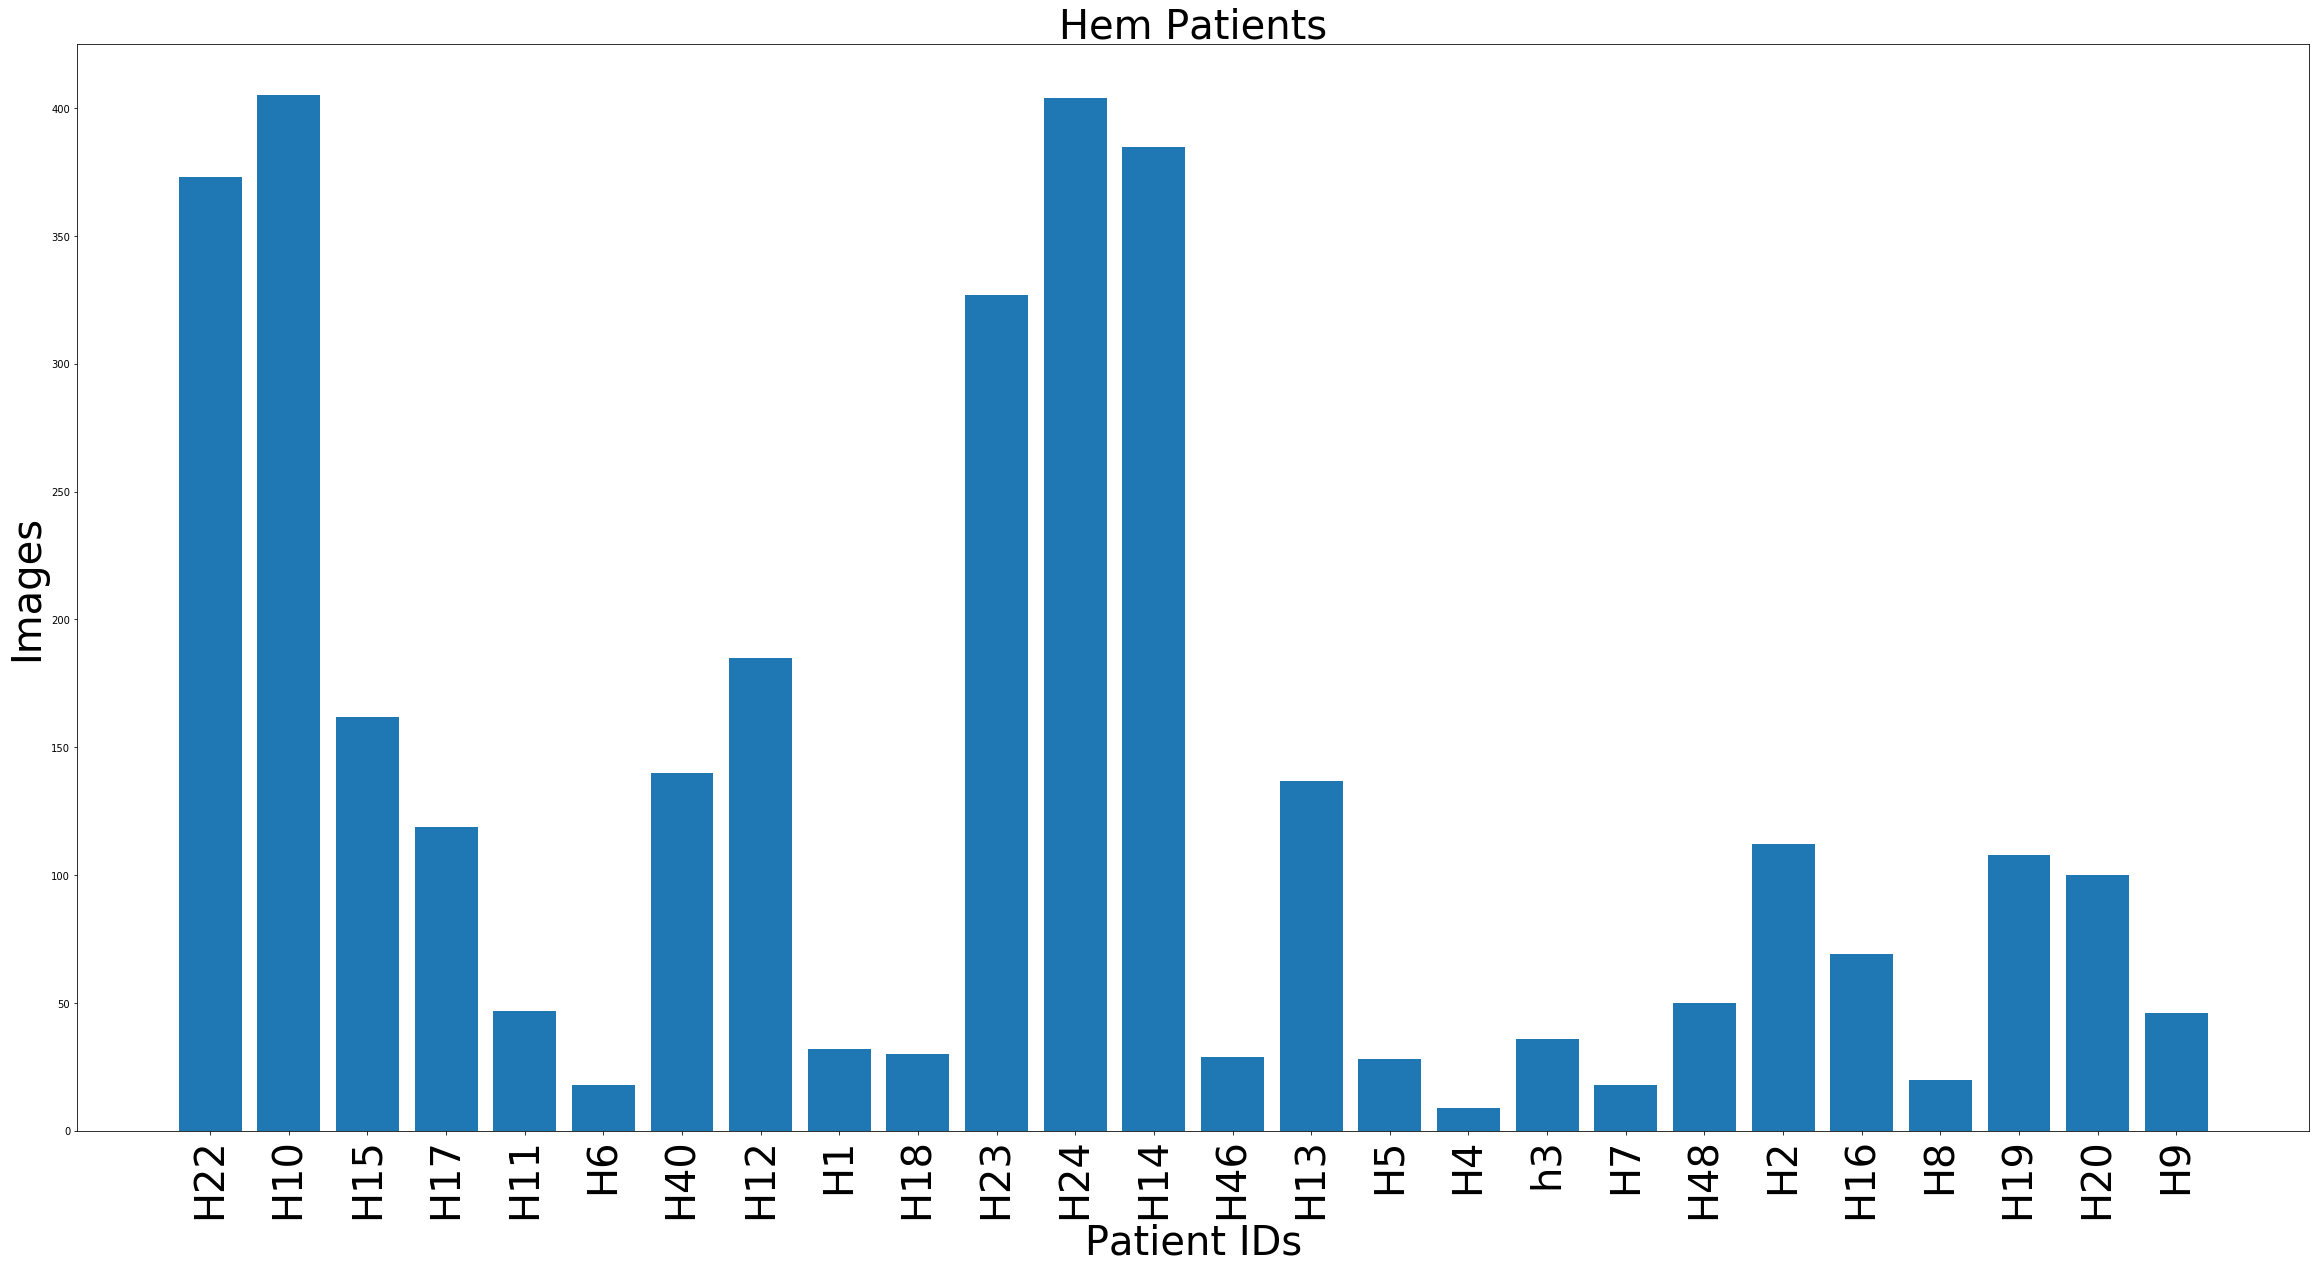

In [14]:
labels, sizes = zip(*[(key, len(hem_patients[key])) for key in hem_patients.keys()])
x_pos = [i for i, _ in enumerate(labels)]

print(np.mean(sizes))
print(min(sizes))
print(max(sizes))

plt.figure(figsize=(40,20))
plt.bar(x_pos, sizes)
plt.xlabel("Patient IDs", fontsize=40)
plt.ylabel("Images", fontsize=40)
plt.title("Hem Patients", fontsize=40)

plt.xticks(x_pos, labels, rotation='vertical', fontsize=40)
plt.show()

## Calc dataset intensity statistics

In [20]:
green_values, red_values, blue_values = None, None, None
for fn in tqdm(hem_files[:150]+all_files[:150]): # use val data!

    image = cv2.cvtColor(cv2.imread(str(fn)), cv2.COLOR_BGR2RGB)

    red_values = image[:, :, 0].flatten() if red_values is None \
        else np.concatenate((red_values, image[:, :, 0].flatten()))

    green_values = image[:, :, 1].flatten() if green_values is None \
        else np.concatenate((green_values, image[:, :, 1].flatten()))

    blue_values = image[:, :, 2].flatten() if blue_values is None \
        else np.concatenate((blue_values, image[:, :, 2].flatten()))

100%|██████████| 300/300 [00:18<00:00, 16.35it/s]


##### With zero pixel

In [21]:
channel_mean = [np.mean(red_values) / 255., np.mean(green_values) / 255., np.mean(blue_values) / 255.]
channel_std = [np.std(red_values) / 255., np.std(green_values) / 255., np.std(blue_values) / 255.]

print(channel_mean)
print(channel_std)

[0.041866073170338095, 0.018006944049059954, 0.0481688492536109]
[0.10050134081387505, 0.04514805563421087, 0.11444067319013998]


##### Without zero pixel

In [22]:
def mean_non_zero(channel : np):
    return np.mean(channel[np.nonzero(channel)]) / 255.

def std_non_zero(channel : np):
    return np.std(channel[np.nonzero(channel)]) / 255.

channel_mean = [mean_non_zero(red_values), mean_non_zero(green_values), mean_non_zero(blue_values)]
channel_std = [std_non_zero(red_values), std_non_zero(green_values), std_non_zero(blue_values)]

print(channel_mean)
print(channel_std)

[0.2708589820139418, 0.11650518799097075, 0.3116339333043732]
[0.05763743603860378, 0.041383301278654853, 0.051242010796232626]


### Create Folds

In [33]:
split_handler = SplitByPatient(hem_patients, all_patints)

In [34]:
folds = split_handler.split_by_folds(5)

In [65]:
for i in range(5):
    hem = [fn for fn in folds[i] if 'hem.bmp' in str(fn)]
    All = [fn for fn in folds[i] if 'all.bmp' in str(fn)]
    
    print("F: {} Hem {} ALL {}".format(i, len(hem), len(All)))

F: 0 Hem 449 ALL 1218
F: 1 Hem 571 ALL 1225
F: 2 Hem 629 ALL 1192
F: 3 Hem 654 ALL 1951
F: 4 Hem 1086 ALL 1686


In [63]:
print(len(hem))
print(len(All))

449
1218


### Cell Visualisation

In [11]:
path = Path('/data/Datasets/WhiteBloodCancer/train/')

In [12]:
pat = re.compile(r'^.*(hem|all).bmp$')

In [13]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=90, max_lighting=0.2, max_zoom=1.5, max_warp=0.3)

In [14]:
data  = ImageDataBunch.from_name_re(path, fnames, pat, ds_tfms=tfms, size=450, bs=32, valid_pct=0.1)       

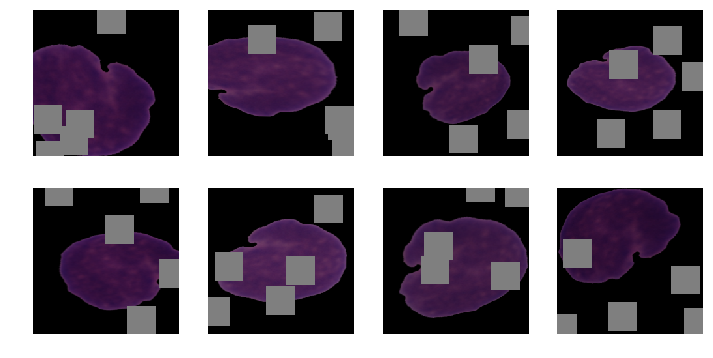

In [57]:
cutout_fn = TfmLighting(cutout)
xtra_tfms=[squish(scale=0.66), cutout_fn(n_holes=5, length=0.2)]
tfms = get_transforms(do_flip=True, 
                      flip_vert=True, 
                      max_rotate=90,  
                      max_lighting=0.15, 
                      max_zoom=1.5, 
                      max_warp=0.2,
                      p_affine=0.75,
                      p_lighting=0.75,  
                      xtra_tfms=xtra_tfms,
                     )

def plots_f(rows, cols, width, height, **kwargs):
    [data.valid_ds[0][0].apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]
    
plots_f(2, 4, 12, 6, size=224)

In [25]:
for i in range(12):
    print(data.valid_ds[i][1])

all
all
all
all
all
hem
all
all
all
hem
all
hem


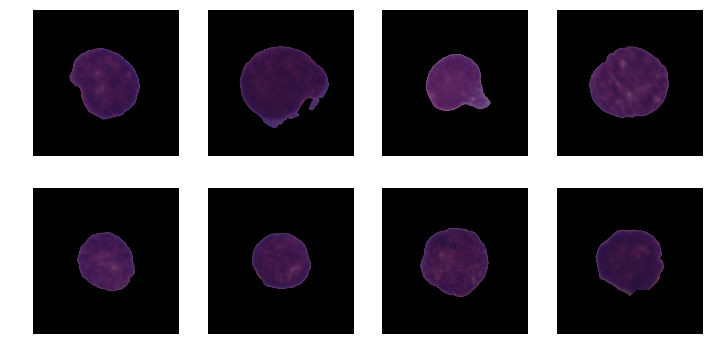

In [16]:
def plots_f(rows, cols, width, height, **kwargs):
    [data.valid_ds[i][0].show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]
    
plots_f(2, 4, 12, 6, size=224)

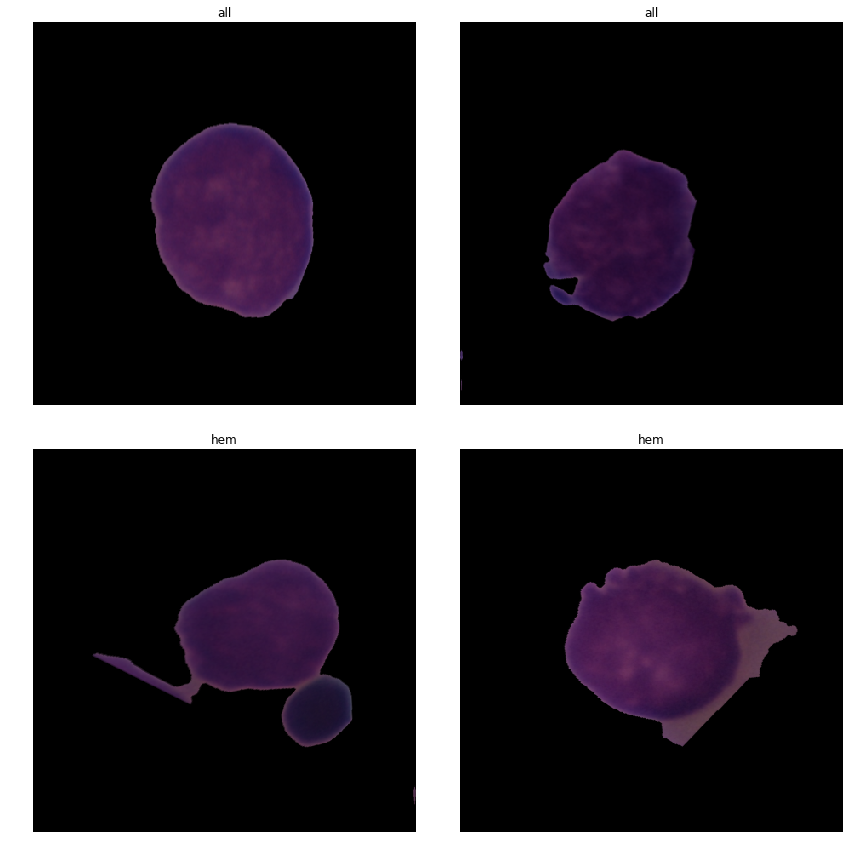

In [46]:
data.show_batch(rows=2, figsize=(12,12))